In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [2]:
!pip install imutils

In [10]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 15
    num_classes = 29
    img_channels = 3
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [5]:
# Labels
TRAIN_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [3]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

In [4]:
sample_images(labels[:10])

NameError: name 'labels' is not defined

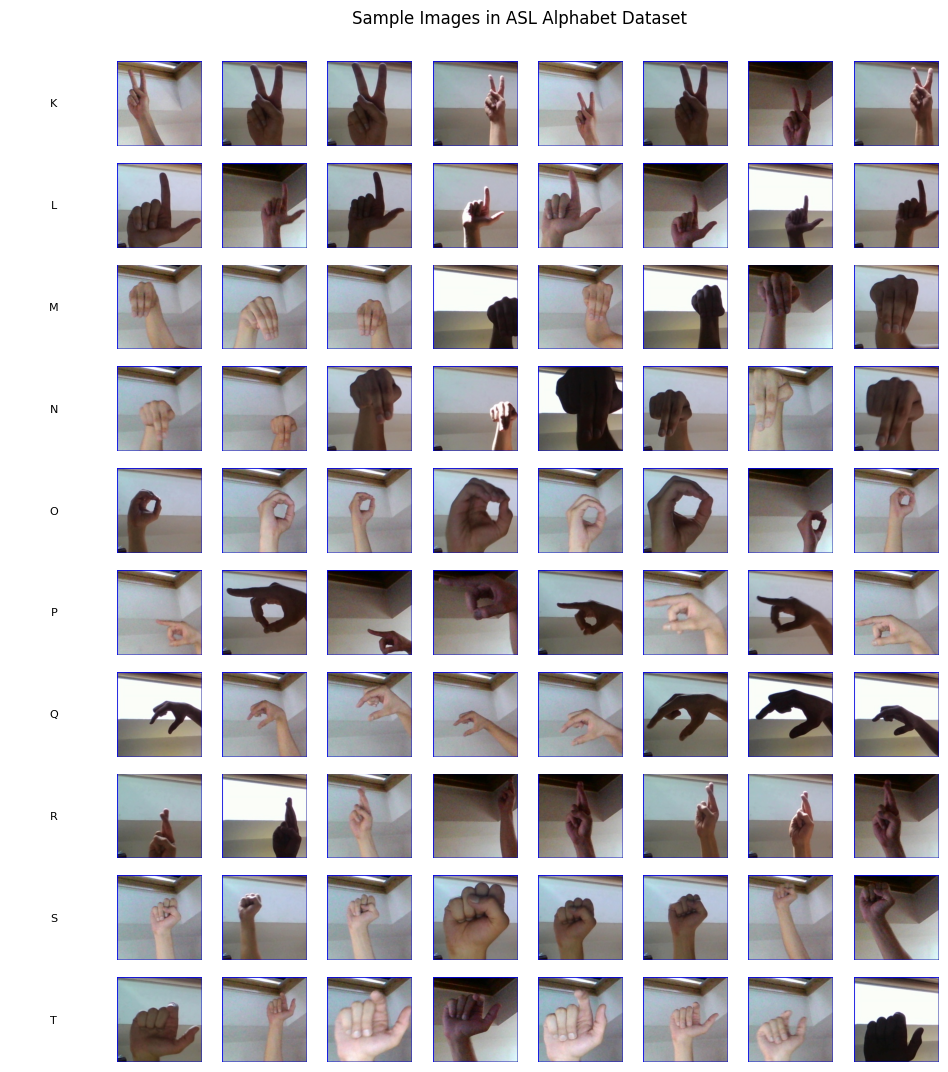

In [7]:
sample_images(labels[10:20])

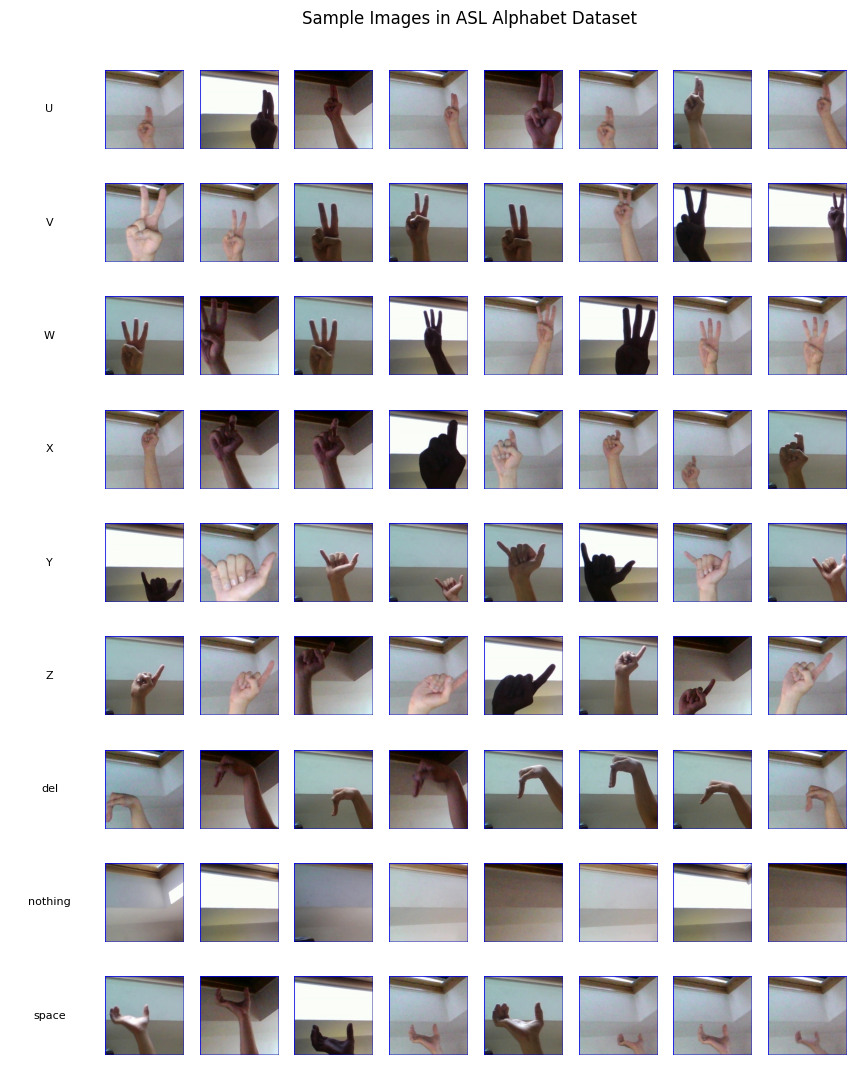

In [8]:
sample_images(labels[20:])

In [9]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A
...,...,...
86995,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86996,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86997,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
86998,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space


In [10]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=2023, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

,image_path,label
51901,/kaggle/input/asl-alphabet/asl_alphabet_train/...,R
51887,/kaggle/input/asl-alphabet/asl_alphabet_train/...,R
5050,/kaggle/input/asl-alphabet/asl_alphabet_train/...,B
29446,/kaggle/input/asl-alphabet/asl_alphabet_train/...,J
58405,/kaggle/input/asl-alphabet/asl_alphabet_train/...,T
...,...,...
47111,/kaggle/input/asl-alphabet/asl_alphabet_train/...,P
83611,/kaggle/input/asl-alphabet/asl_alphabet_train/...,nothing
67329,/kaggle/input/asl-alphabet/asl_alphabet_train/...,W
85296,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space


,image_path,label
24961,/kaggle/input/asl-alphabet/asl_alphabet_train/...,I
71053,/kaggle/input/asl-alphabet/asl_alphabet_train/...,X
73637,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
72875,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
40669,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
...,...,...
16474,/kaggle/input/asl-alphabet/asl_alphabet_train/...,F
62741,/kaggle/input/asl-alphabet/asl_alphabet_train/...,U
32281,/kaggle/input/asl-alphabet/asl_alphabet_train/...,K
20451,/kaggle/input/asl-alphabet/asl_alphabet_train/...,G


,image_path,label
73327,/kaggle/input/asl-alphabet/asl_alphabet_train/...,Y
85482,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
65607,/kaggle/input/asl-alphabet/asl_alphabet_train/...,V
53903,/kaggle/input/asl-alphabet/asl_alphabet_train/...,R
64425,/kaggle/input/asl-alphabet/asl_alphabet_train/...,V
...,...,...
40578,/kaggle/input/asl-alphabet/asl_alphabet_train/...,N
28949,/kaggle/input/asl-alphabet/asl_alphabet_train/...,J
42094,/kaggle/input/asl-alphabet/asl_alphabet_train/...,O
5425,/kaggle/input/asl-alphabet/asl_alphabet_train/...,B


In [11]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [12]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

None

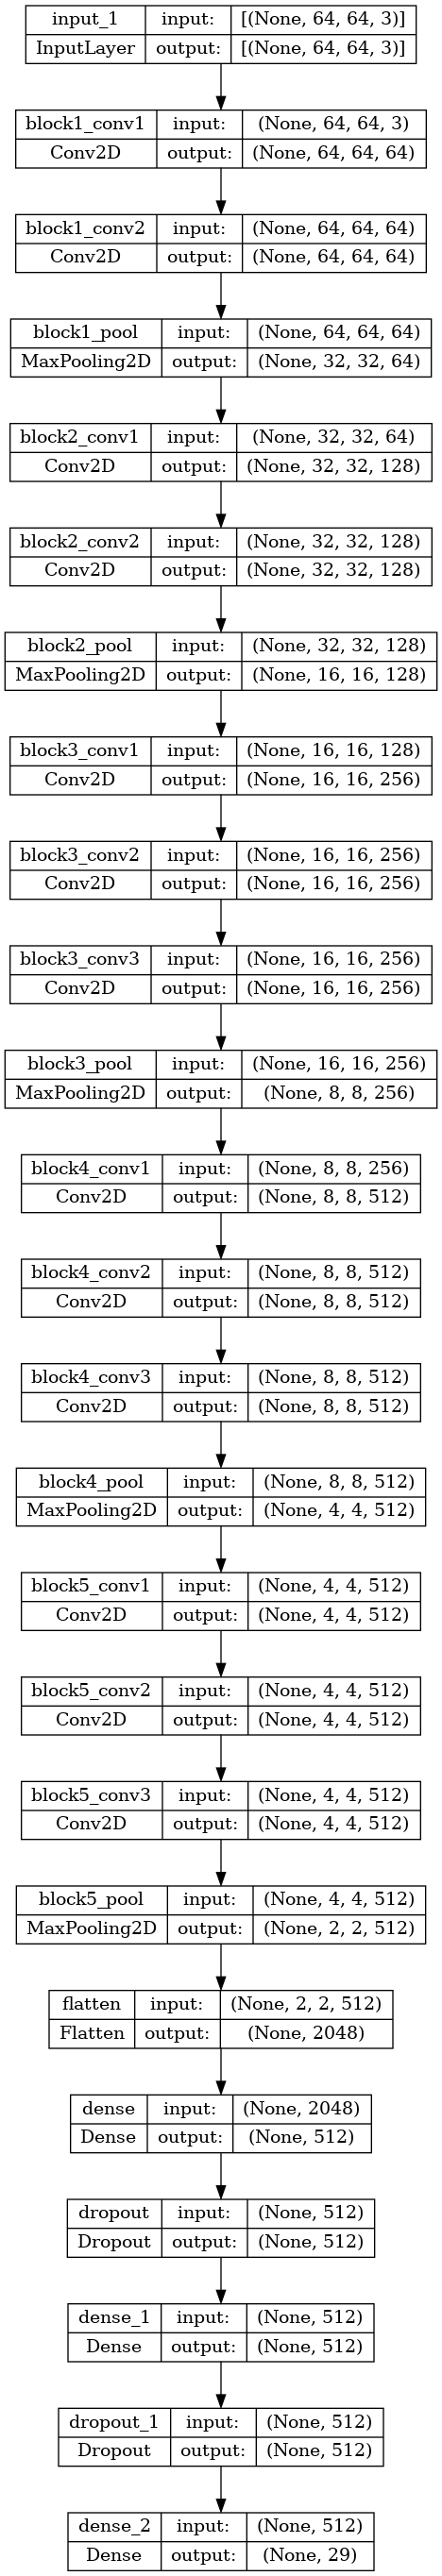

In [13]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

In [14]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [15]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/15
907/907 [==============================] - 377s 409ms/step - loss: 1.0979 - accuracy: 0.6538 - val_loss: 0.2566 - val_accuracy: 0.9180
Epoch 2/15
907/907 [==============================] - 92s 102ms/step - loss: 0.3973 - accuracy: 0.8653 - val_loss: 0.1349 - val_accuracy: 0.9597
Epoch 3/15
907/907 [==============================] - 95s 105ms/step - loss: 0.2890 - accuracy: 0.9019 - val_loss: 0.0964 - val_accuracy: 0.9720
Epoch 4/15
907/907 [==============================] - 92s 101ms/step - loss: 0.2522 - accuracy: 0.9132 - val_loss: 0.0719 - val_accuracy: 0.9786
Epoch 5/15
907/907 [==============================] - 91s 100ms/step - loss: 0.2179 - accuracy: 0.9260 - val_loss: 0.0813 - val_accuracy: 0.9739
Epoch 6/15
907/907 [==============================] - 94s 104ms/step - loss: 0.1913 - accuracy: 0.9342 - val_loss: 0.0468 - val_accuracy: 0.9853
Epoch 7/15
907/907 [==============================] - 92s 101ms/step - loss: 0.1870 - accuracy: 0.9359 - val_loss: 0.0614 - val_a

In [16]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

13050/13050 [==============================] - 95s 7ms/step - loss: 0.0234 - accuracy: 0.9920
Evaluate Test Accuracy: 99.20%


In [17]:
# Confusion Matrix
fine_tuned_model = load_model("/kaggle/working/asl_vgg16_best_weights.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 47s 4ms/step


In [18]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-1].output)

# Summarize the `dense_model`
dense_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [19]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from PIL import Image  # Import PIL for image resizing

# Define the function for extracting dense features from an image
def dense_feature_prediction(img_path):
    # Define the image dimensions here
    CFG = {
        "img_height": 64,
        "img_width": 64,
    }

    img = load_img(img_path, target_size=(CFG['img_height'], CFG['img_width']))
    img = img_to_array(img)
    img / 255.0
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction = []

# List of labels

# Loop through labels, extract data, and create the reduction list
for label in labels:
    label_data = data_test[data_test["label"] == label][:100]
    reduction.extend(label_data.values)

reduction_data = pd.DataFrame(reduction, columns=["image_path", "label"])

# Display the reduction_data DataFrame
print(reduction_data)

# Apply the dense_feature_prediction function to each image path in the "image_path" column
dense_features = reduction_data["image_path"].progress_apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values.tolist(), index=dense_features.index)


# Now, 'dense_features' contains the dense features extracted from the images


                                             image_path  label
0     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
1     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
2     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
3     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
4     /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
...                                                 ...    ...
2895  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2896  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2897  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2898  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
2899  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space

[2900 rows x 2 columns]


100%|██████████| 2900/2900 [02:37<00:00, 18.41it/s]


In [20]:
 #Assuming you have 'dense_features' as your input data
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)

# Create a DataFrame to store the t-SNE results
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])

# Assuming you have a DataFrame called 'reduction_data'
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data
# Now, 'reduction_data' contains the t-SNE results in columns 'tsne_feat_0' and 'tsne_feat_1'
# You can perform further analysis or visualization using these reduced features

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.001s...
[t-SNE] Computed neighbors for 2900 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.579041
[t-SNE] KL divergence after 1000 iterations: -1.264669


,image_path,label,tsne_feat_0,tsne_feat_1
0,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,-10.710557,57.157623
1,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,-12.840606,57.771084
2,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,28.358824,56.824497
3,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,31.201445,56.689972
4,/kaggle/input/asl-alphabet/asl_alphabet_train/...,A,23.479977,50.883675
...,...,...,...,...
2895,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space,-15.400793,-34.622608
2896,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space,-15.400793,-34.622608
2897,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space,-15.400793,-34.622608
2898,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space,-15.400793,-34.622608


In [21]:
# Load the saved model
model = tf.keras.models.load_model('/kaggle/working/asl_vgg16_best_weights.h5')
# Load the test image
image_path = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/B_test.jpg"
img= cv2.imread(image_path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img= cv2.resize(img, (64, 64))
# Preprocess the image
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
# Make predictions on the image
predictions = model.predict(np.array([img]))
# Get the predicted class label
predicted_class = labels [np.argmax(predictions)]
print(f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 158ms/step
The predicted class is B


In [22]:
model = tf.keras.models.load_model('/kaggle/working/asl_vgg16_best_weights.h5')
# Load the test image
image_path = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg"
img= cv2.imread(image_path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img= cv2.resize(img, (64, 64))
# Preprocess the image.
img= tf.keras.applications.mobilenet_v2.preprocess_input(img)
# Make predictions on the image
predictions = model.predict(np.array([img]))
# Get the predicted class label
predicted_class = labels [np.argmax (predictions)]
print (f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 201ms/step
The predicted class is A


In [23]:
model = tf.keras.models.load_model('/kaggle/working/asl_vgg16_best_weights.h5')
# Load the test image
image_path = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/H_test.jpg"
img= cv2.imread(image_path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img= cv2.resize(img, (64, 64))
# Preprocess the image.
img= tf.keras.applications.mobilenet_v2.preprocess_input(img)
# Make predictions on the image
predictions = model.predict(np.array([img]))
# Get the predicted class label
predicted_class = labels [np.argmax (predictions)]
print (f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 204ms/step
The predicted class is H


In [24]:
model = tf.keras.models.load_model('/kaggle/working/asl_vgg16_best_weights.h5')
# Load the test image
image_path = "/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg"
img= cv2.imread(image_path)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img= cv2.resize(img, (64, 64))
# Preprocess the image.
img= tf.keras.applications.mobilenet_v2.preprocess_input(img)
# Make predictions on the image
predictions = model.predict(np.array([img]))
# Get the predicted class label
predicted_class = labels [np.argmax (predictions)]
print (f"The predicted class is {predicted_class}")

1/1 [==============================] - 0s 193ms/step
The predicted class is nothing
